In [ ]:
import json
from pathlib import Path

import h5py
import libero.libero.utils.utils as libero_utils
import numpy as np
import robosuite
import robosuite.utils.transform_utils as T
from libero.libero import get_default_path_dict
from libero.libero.envs import *

LIBERO_DATASETS_PATH = Path("/mnt/hdd/LIBERO-datasets")
ROBOSUITE_PATH = Path(robosuite.__path__[0])


def load_demo_file(libero_suite, task_name):
    dataset_path = LIBERO_DATASETS_PATH / libero_suite / f"{task_name}_demo.hdf5"
    if not dataset_path.exists():
        raise FileNotFoundError(f"HDF5 file not found at {dataset_path}")
    return h5py.File(dataset_path, "r")

[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /home/min99830/Projects/vla0-trl/.venv/lib/python3.11/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Original Replay

In [ ]:
test_suite, test_task = "libero_goal", "open_the_middle_drawer_of_the_cabinet"

demo_hdf5 = load_demo_file(test_suite, test_task)

env_name = demo_hdf5["data"].attrs["env_name"]
env_args = demo_hdf5["data"].attrs["env_args"]
env_kwargs = json.loads(demo_hdf5["data"].attrs["env_args"])

problem_info = json.loads(demo_hdf5["data"].attrs["problem_info"])
problem_name = problem_info["problem_name"]
language_instruction = problem_info["language_instruction"]

demos = list(demo_hdf5["data"].keys())

bddl_file_name = demo_hdf5["data"].attrs["bddl_file_name"]
bddl_file_name = (
    get_default_path_dict()["bddl_files"]
    + "/"
    + bddl_file_name.split("libero/libero/bddl_files/")[1]
)

libero_utils.update_env_kwargs(
    env_kwargs,
    bddl_file_name=bddl_file_name,
    has_renderer=False,
    has_offscreen_renderer=True,
    ignore_done=True,
    use_camera_obs=True,
    camera_depths=True,
    camera_names=[
        "robot0_eye_in_hand",
        "agentview",
    ],
    # Not in the original demo, but we set this to ensure consistency #
    robots=["Panda"],
    controller_configs=robosuite.load_controller_config(default_controller="OSC_POSE"),
    ###################################################################
    reward_shaping=True,
    control_freq=20,
    camera_heights=256,
    camera_widths=256,
    camera_segmentations=None,
)

env_args = {
    "type": 1,
    "env_name": env_name,
    "problem_name": problem_name,
    "bddl_file": bddl_file_name,
    "env_kwargs": env_kwargs,
}

for key in env_args.keys():
    env_kwargs.pop(key)

env = TASK_MAPPING[problem_name](
    **env_kwargs,
)

env_args = {
    "type": 1,
    "env_name": env_name,
    "problem_name": problem_name,
    "bddl_file": bddl_file_name,
    "env_kwargs": env_kwargs,
}

for i, ep in enumerate(demos):
    print("Playing back random episode... (press ESC to quit)")

    model_xml = demo_hdf5["data/{}".format(ep)].attrs["model_file"]
    reset_success = False

    while not reset_success:
        try:
            env.reset()
            reset_success = True
        except:
            continue

    model_xml = libero_utils.postprocess_model_xml(model_xml, {})
    states = demo_hdf5["data/{}/states".format(ep)][()]
    actions = demo_hdf5["data/{}/actions".format(ep)][()]

    num_actions = actions.shape[0]

    init_idx = 0
    env.reset_from_xml_string(model_xml)
    env.sim.reset()
    env.sim.set_state_from_flattened(states[init_idx])
    env.sim.forward()
    model_xml = env.sim.model.get_xml()

    ee_states = []
    gripper_states = []
    joint_states = []
    robot_states = []

    agentview_images = []
    eye_in_hand_images = []

    agentview_depths = []
    eye_in_hand_depths = []

    rewards = []
    dones = []

    valid_index = []

    cap_index = 5

    # print(env.action_dim)
    # print(env.action_spec)

    for j, action in enumerate(actions):

        obs, reward, done, info = env.step(action)

        if j < num_actions - 1:
            state_playback = env.sim.get_state().flatten()

            err = np.linalg.norm(states[j + 1] - state_playback)

            if err > 0.01:
                print(
                    f"State mismatch at step {j}: recorded vs playback error = {err}."
                )

        if j < cap_index:
            continue

        valid_index.append(j)

        gripper_states.append(obs["robot0_gripper_qpos"])

        joint_states.append(obs["robot0_joint_pos"])

        ee_states.append(
            np.hstack((obs["robot0_eef_pos"], T.quat2axisangle(obs["robot0_eef_quat"])))
        )

        robot_states.append(env.get_robot_state_vector(obs))

        agentview_depths.append(obs["agentview_depth"])
        eye_in_hand_depths.append(obs["robot0_eye_in_hand_depth"])

        agentview_images.append(obs["agentview_image"])
        eye_in_hand_images.append(obs["robot0_eye_in_hand_image"])

    states = states[valid_index]
    actions = actions[valid_index]
    dones = np.zeros(len(actions)).astype(np.uint8)
    dones[-1] = 1
    rewards = np.zeros(len(actions)).astype(np.uint8)
    rewards[-1] = 1

    assert len(actions) == len(
        agentview_images
    ), f"{len(actions)} vs {len(agentview_images)}"
    break

Playing back random episode... (press ESC to quit)
State mismatch at step 0: recorded vs playback error = 0.18601326449529318.
State mismatch at step 1: recorded vs playback error = 0.054787850581225574.
State mismatch at step 2: recorded vs playback error = 0.04112228728336398.
State mismatch at step 3: recorded vs playback error = 0.0815485315112344.
State mismatch at step 4: recorded vs playback error = 0.060093286768205925.
State mismatch at step 5: recorded vs playback error = 0.03581124905451504.
State mismatch at step 6: recorded vs playback error = 0.02266426345671171.
State mismatch at step 7: recorded vs playback error = 0.016142453610504603.
State mismatch at step 8: recorded vs playback error = 0.013633199915385126.
State mismatch at step 9: recorded vs playback error = 0.012914111968133966.
State mismatch at step 10: recorded vs playback error = 0.01281953061912474.
State mismatch at step 11: recorded vs playback error = 0.01299967767042961.
State mismatch at step 12: reco

In [ ]:
len(agentview_images)

133

In [ ]:
import matplotlib.pyplot as plt

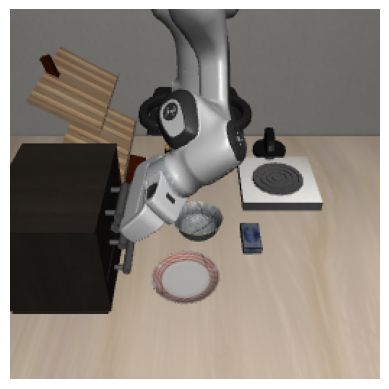

In [ ]:
plt.axis("off")
plt.imshow(agentview_images[80][::-1, :, :])

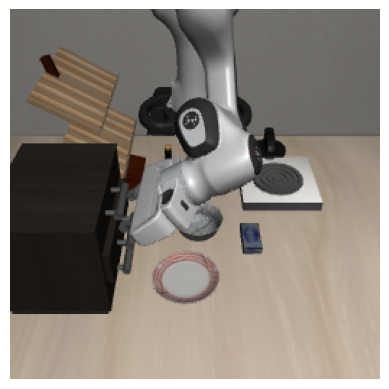

In [ ]:
plt.axis("off")
plt.imshow(agentview_images[100][::-1, :, :])

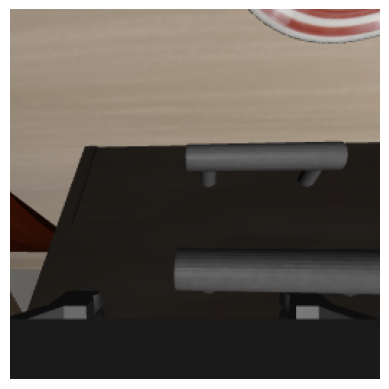

In [ ]:
plt.axis("off")
plt.imshow(eye_in_hand_images[100][::-1, :, :])

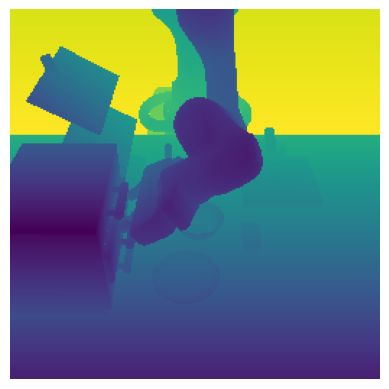

In [ ]:
plt.axis("off")
plt.imshow(agentview_depths[100][::-1, :])

# Measurement VQA

In [ ]:
# Get model and data from simulator
model = env.sim.model
data = env.sim.data

In [ ]:
problem = env.parsed_problem

print(problem["initial_state"])
print(problem["goal_state"])

[['on', 'wine_bottle_1', 'main_table_wine_bottle_region'], ['on', 'akita_black_bowl_1', 'main_table_akita_black_bowl_region'], ['on', 'plate_1', 'main_table_plate_region'], ['on', 'cream_cheese_1', 'main_table_cream_cheese_region'], ['on', 'wooden_cabinet_1', 'main_table_cabinet_region'], ['on', 'flat_stove_1', 'main_table_stove_region'], ['on', 'wine_rack_1', 'main_table_wine_rack_region']]
[['open', 'wooden_cabinet_1_middle_region']]


In [ ]:
def get_all_names(model):
    # Mujoco 2.x python bindings
    names = {}

    names["body"] = [model.body(i).name for i in range(model.nbody)]
    names["site"] = [model.site(i).name for i in range(model.nsite)]
    names["geom"] = [model.geom(i).name for i in range(model.ngeom)]

    return names


def name2id(model, kind, name):
    """
    kind: 'body' | 'site' | 'geom'
    """

    fn = getattr(model, f"{kind}_name2id", None)
    if fn is not None:
        return int(fn(name))

    # Fallback: find index in names list
    names = get_all_names(model)[kind]
    return int(names.index(name))


def get_body_pos(model, data, body_name):
    bid = name2id(model, "body", body_name)
    return data.body_xpos[bid].copy()


def get_site_pos(model, data, site_name):
    sid = name2id(model, "site", site_name)
    return data.site_xpos[sid].copy()


def get_geom_pos(model, data, geom_name):
    gid = name2id(model, "geom", geom_name)
    return data.geom_xpos[gid].copy()


def get_gripper_pos(model, data, eef_site_name="gripper0_grip_site"):
    return get_site_pos(model, data, eef_site_name)


def resolve_object_entity(model, obj_query, prefer=("body", "site", "geom")):
    """
    obj_query: ex) "mug", "drawer_handle", "cube"
    return: (kind, name)
    """
    names = get_all_names(model)
    q = obj_query.lower()

    # 1) exact match
    for kind in prefer:
        for n in names.get(kind, []):
            if n.lower() == q:
                return kind, n

    # 2) substring match
    hits = []
    for kind in prefer:
        for n in names.get(kind, []):
            if q in n.lower():
                hits.append((kind, n))
    if hits:
        hits.sort(key=lambda kn: (len(kn[1]), kn[1]))
        return hits[0]

    raise RuntimeError(f"'{obj_query}' not found in model.")


def get_object_pos(model, data, obj_query, resolved=None):
    if resolved is None:
        resolved = resolve_object_entity(model, obj_query)
    kind, name = resolved
    if kind == "body":
        return get_body_pos(model, data, name)
    if kind == "site":
        return get_site_pos(model, data, name)
    if kind == "geom":
        return get_geom_pos(model, data, name)
    raise ValueError(resolved)


def get_closest_distance(model, data, objA_query):
    import mujoco

    def body_geoms(model, body_id):
        adr = model.body_geomadr[body_id]
        num = model.body_geomnum[body_id]
        return list(range(adr, adr + num))

    def get_gripper_geom_ids(model):
        GRIPPER_GEOM_NAMES = [
            "gripper0_hand_visual",
            "gripper0_hand_collision",
            "gripper0_finger1_visual",
            "gripper0_finger1_collision",
            "gripper0_finger1_pad_collision",
            "gripper0_finger2_visual",
            "gripper0_finger2_collision",
            "gripper0_finger2_pad_collision",
        ]

        names = []
        for gid in range(model.ngeom):
            n = model.geom(gid).name

            if n is None:
                continue

            if n in GRIPPER_GEOM_NAMES:
                names.append((gid, n))

        return [gid for gid, _ in names]

    def geom_distance(model, data, geom1, geom2, distmax=1e9):
        fromto = np.zeros((2, 3), dtype=np.float64)
        d = mujoco.mj_geomDistance(
            model._model, data._data, geom1, geom2, float(distmax), fromto
        )
        return float(d), fromto.copy()

    gripper_geom_ids = get_gripper_geom_ids(model)
    _, objA_name = resolve_object_entity(model, objA_query, prefer=("body",))
    obj_bid = model.body_name2id(objA_name)
    objA_geom_ids = body_geoms(model, obj_bid)

    best = (1e9, None, None, None)  # dist, g1, g2, fromto

    for g1 in gripper_geom_ids:
        for g2 in objA_geom_ids:
            d, fromto = geom_distance(model, data, g1, g2)
            if d < best[0]:
                best = (d, g1, g2, fromto)

    return best


# Sanity Check for methods

cabinet_pos = get_body_pos(model, data, "wooden_cabinet_1_cabinet_middle")
cabinet_obj_pos = get_object_pos(model, data, "wooden_cabinet_1_middle_region")
gripper_pos = get_gripper_pos(model, data, "gripper0_grip_site")
closest_distance = get_closest_distance(model, data, "wooden_cabinet_1_cabinet_middle")

print(cabinet_pos)
print(cabinet_obj_pos)
print(gripper_pos, ee_states[-1][:3])  # Should be very close)
print(closest_distance[0])

[ 0.0299718 -0.0754493  0.905    ]
[ 0.0266918 -0.0867293  1.0219   ]
[0.00949582 0.07299275 1.01647998] [0.00949582 0.07299275 1.01647998]
0.02916749533491106


In [ ]:
# Templates
MEASUREMENT_VQA = [  # (Question, Answer) Tuples
    (
        "Is {OBJ_A} closer to the gripper than {OBJ_B}?",
        "Answer: {ANSWER}",
    ),  # M1, Binary
    (
        "Is the gripper within {TH}cm of {OBJ_A}?",
        "Answer: {ANSWER}",
    ),  # M2, Numeric Binary
    (
        "What is the height difference between {OBJ_A} and the gripper (in cm)?\nA1. {C1}\nA2. {C2}\nA3. {C3}\nA4. {C4}\nA5. {C5}",
        "Answer: {ANSWER}",
    ),  # M3, Multiple Choice (5 options)
]


def get_measurement_vqa(env, objA="cabinet_middle", objB="wine", th=10):
    """
    returns: list of (prompt, answer) tuples
    """
    model = env.sim.model
    data = env.sim.data

    def answer_M1_closer_than(model, data, objA, objB):
        dA = get_closest_distance(model, data, objA)[0]
        dB = get_closest_distance(model, data, objB)[0]
        return "Yes" if dA < dB else "No"

    def answer_M2_within_threshold(model, data, objA, TH_cm):
        dA = get_closest_distance(model, data, objA)[0]
        return "Yes" if dA <= TH_cm / 100.0 else "No"

    def answer_M3_height_difference_mcq(model, data, objA, step=1.0, spread=10.0):
        def make_height_mcq_choices(true_val_cm, step=1.0, spread=10.0):
            import random

            tv = round(true_val_cm / step) * step

            candidates = set([tv])
            while len(candidates) < 5:
                perturb = random.uniform(-spread, spread)
                v = round((tv + perturb) / step) * step
                candidates.add(v)

            choices = list(candidates)
            random.shuffle(choices)

            correct_idx = choices.index(tv)
            return choices, correct_idx

        _, _, _, fromto = get_closest_distance(model, data, objA)

        dz_cm = (fromto[1][2] - fromto[0][2]) * 100.0  # in cm

        choices, correct_idx = make_height_mcq_choices(dz_cm, step=step, spread=spread)
        answer = f"A{correct_idx + 1}"
        return answer, choices

    prompts_answers = []
    question_m1, answer_m1 = MEASUREMENT_VQA[0]
    question_m1 = question_m1.format(OBJ_A=objA, OBJ_B=objB)
    answer_m1_answer = answer_M1_closer_than(model, data, objA, objB)
    prompts_answers.append((question_m1, answer_m1.format(ANSWER=answer_m1_answer)))

    question_m2, answer_m2 = MEASUREMENT_VQA[1]
    question_m2 = question_m2.format(OBJ_A=objA, TH=th)
    answer_m2_answer = answer_M2_within_threshold(model, data, objA, th)
    prompts_answers.append((question_m2, answer_m2.format(ANSWER=answer_m2_answer)))
    answer_m3_answer, choices = answer_M3_height_difference_mcq(model, data, objA)
    question_m3, answer_m3 = MEASUREMENT_VQA[2]
    question_m3 = question_m3.format(
        OBJ_A=objA,
        C1=choices[0],
        C2=choices[1],
        C3=choices[2],
        C4=choices[3],
        C5=choices[4],
    )
    prompts_answers.append((question_m3, answer_m3.format(ANSWER=answer_m3_answer)))

    return prompts_answers


get_measurement_vqa(env)

[('Is cabinet_middle closer to the gripper than wine?', 'Answer: Yes'),
 ('Is the gripper within 10cm of cabinet_middle?', 'Answer: Yes'),
 ('What is the height difference between cabinet_middle and the gripper (in cm)?\nA1. -4.0\nA2. 7.0\nA3. -3.0\nA4. -9.0\nA5. 0.0',
  'Answer: A5')]

In [ ]:
print(
    "What is the height difference between cabinet_middle and the gripper (in cm)?\nA1. -56.0\nA2. -12.0\nA3. -44.0\nA4. -34.0\nA5. -62.0"
)

What is the height difference between cabinet_middle and the gripper (in cm)?
A1. -56.0
A2. -12.0
A3. -44.0
A4. -34.0
A5. -62.0


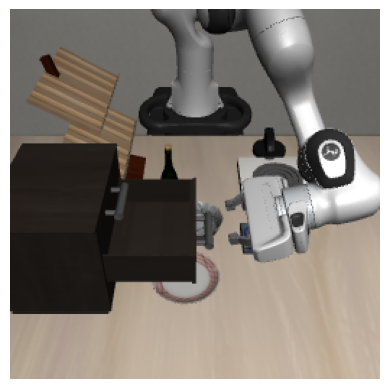

In [ ]:
plt.axis("off")
plt.imshow(obs["agentview_image"][::-1, :, :])

In [ ]:
from datasets import load_from_disk

ds = load_from_disk("/mnt/hdd/processed/measurement_vqa_10_hf")

/home/min99830/Projects/vla0-trl/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ds

Dataset({
    features: ['suite', 'task', 'episode_id', 'step_idx', 'objects', 'oracle', 'questions', 'state_error', 'agentview_image', 'eye_in_hand_image'],
    num_rows: 550
})

In [ ]:
ds.column_names

['suite',
 'task',
 'episode_id',
 'step_idx',
 'objects',
 'oracle',
 'questions',
 'state_error',
 'agentview_image',
 'eye_in_hand_image']

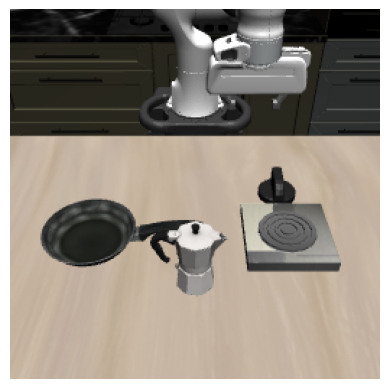

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.axis("off")
plt.imshow(ds[1]["agentview_image"])

In [5]:
ds[1]["questions"]

[{'answer': 'No',
  'choices': None,
  'id': 'M1',
  'question': 'Is moka_pot_1 closer to the gripper than chefmate_8_frypan_1?'},
 {'answer': 'No',
  'choices': None,
  'id': 'M2',
  'question': 'Is the gripper within 10cm of moka_pot_1?'},
 {'answer': 'A5',
  'choices': [12.0, 7.0, 11.0, 20.0, 13.0],
  'id': 'M3',
  'question': 'What is the height difference between moka_pot_1 and the gripper (in cm)?\nA1. 12.0\nA2. 7.0\nA3. 11.0\nA4. 20.0\nA5. 13.0'}]

In [ ]:
ds[0]["questions"]

[{'answer': 'No',
  'choices': None,
  'id': 'M1',
  'question': 'Is moka_pot_1 closer to the gripper than chefmate_8_frypan_1?'},
 {'answer': 'No',
  'choices': None,
  'id': 'M2',
  'question': 'Is the gripper within 10cm of moka_pot_1?'},
 {'answer': 'A2',
  'choices': [9.0, 14.0, 8.0, 23.0, 15.0],
  'id': 'M3',
  'question': 'What is the height difference between moka_pot_1 and the gripper (in cm)?\nA1. 9.0\nA2. 14.0\nA3. 8.0\nA4. 23.0\nA5. 15.0'}]

In [ ]:
ds[6]["questions"]

[{'answer': 'Yes',
  'choices': None,
  'id': 'M1',
  'question': 'Is moka_pot_1 closer to the gripper than chefmate_8_frypan_1?'},
 {'answer': 'Yes',
  'choices': None,
  'id': 'M2',
  'question': 'Is the gripper within 10cm of moka_pot_1?'},
 {'answer': 'A4',
  'choices': [-17.0, -3.0, -18.0, -8.0, -12.0],
  'id': 'M3',
  'question': 'What is the height difference between moka_pot_1 and the gripper (in cm)?\nA1. -17.0\nA2. -3.0\nA3. -18.0\nA4. -8.0\nA5. -12.0'}]